# Подготовка

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
from tqdm import tqdm
from itertools import product
from collections import Counter,defaultdict
from sklearn.model_selection import train_test_split, GroupKFold,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV 
import lightgbm
from lightgbm import LGBMClassifier
import xgboost
from xgboost import plot_importance
from scipy.sparse import coo_matrix, vstack
import scipy
import pickle
import statistics
import random
import itertools

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from Bio import SeqIO

import seaborn as sns
sns.set_theme()

In [7]:
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, classification_report
import numpy as np

from fastsk import (
    FastSK,
    FastaUtility,
)
from sklearn.manifold import TSNE

In [8]:
PATH_FASTSK_FEATURES = '/home/parazit/ml_virus_host/v2.0/fastsk/Features/'
PATH_SAMPLE_IDS = '/home/parazit/ml_virus_host/v2.0/sample_ids/'
PATH_FASTSK_DATA = '/home/parazit/ml_virus_host/v2.0/fastsk/data/'
PATH_DATA = '/home/parazit/ml_virus_host/v2.0/data/'
PATH_FASTSK_REPORTS = '/home/parazit/ml_virus_host/v2.0/fastsk/Reports/'
PATH_FIGS = '/home/parazit/ml_virus_host/v2.0/figs/'
PATH_FASTSK_RANGED_REPORTS = '/home/parazit/ml_virus_host/v2.0/fastsk/Reports/ranged/'
PATH_FEATURES = '/home/parazit/ml_virus_host/v2.0/Features/'

In [9]:
future_sample_id_uncrossing = pickle.load(open(PATH_SAMPLE_IDS + 'uncrossing_sample.pkl', 'rb'))[0]
future_sample_id_rhab = pickle.load(open(PATH_SAMPLE_IDS + 'rhabdoviridae_sample.pkl', 'rb'))
future_sample_id_crossing = pickle.load(open(PATH_SAMPLE_IDS + 'crossing_sample.pkl', 'rb'))

In [10]:
meta_df = pd.read_csv(PATH_FASTSK_DATA+'data_table.tsv', sep='\t', index_col='refseq id')
y = np.array(meta_df['host'])

pre = preprocessing.LabelEncoder()
pre.fit(['Insecta', 'Mammalia', 'Viridiplantae'])  
y_int = pre.transform(y)
family = np.array(meta_df['virus family'])

y_insects = np.array(y_int == 0).astype(int)
y_mammals = np.array(y_int == 1).astype(int)
y_plants = np.array(y_int == 2).astype(int) 


list_y = [y_insects, y_mammals, y_plants]
classes = ['Insecta', 'Mammalia', 'Viridiplantae']

meta_df['i'] = y_insects
meta_df['m'] = y_mammals
meta_df['p'] = y_plants
meta_df['indices'] = list(range(len(meta_df)))

print(y[:3])
print(y_int[:3])

['Mammalia' 'Viridiplantae' 'Insecta']
[1 2 0]


# Временные исправления

In [ ]:
meta_df=pd.read_csv(PATH_DATA+'data_table.tsv', sep='\t', index_col = 'refseq id')

In [39]:
#with open(PATH_FASTSK_DATA+'meta_df_fixed.csv', 'w'):
df = meta_df.head(0)
for seq in SeqIO.parse(PATH_DATA+'data.fasta', 'fasta'):
    df = df.append(meta_df.loc[seq.id])
df.to_csv(PATH_FASTSK_DATA+'data_table.tsv', sep='\t', index='refseq id')

# Uncrossing data preparation

In [6]:
test_ids, train_ids, test_indices_uncrossing, train_indices_uncrossing = [], [], {}, {}
for class_k in ['i', 'm', 'p']:
    test_index = []
    train_index = []
    seq_id_test = []
    with open(PATH_FASTSK_DATA+'uncrossing/full_uncrossing_test_'+ class_k +'.fasta', 'w') as test_f, \
    open(PATH_FASTSK_DATA+'uncrossing/full_uncrossing_train_'+ class_k +'.fasta', 'w') as train_f:
        i = -1
        for seq in SeqIO.parse(PATH_DATA+'data.fasta', 'fasta'):
            i+=1
            #print(seq.id)
            if not i == meta_df.loc[seq.id]['indices']:
                print('FAIL', i, seq.id, meta_df.loc[seq.id]['indices'])
            if seq.id in future_sample_id_uncrossing:
                seq_id_test.append(seq.id)
                test_index.append(i)
                seq.description = str(meta_df.loc[seq.id][class_k])
                seq.id = seq.description
                SeqIO.write(seq, test_f, 'fasta-2line')
            else:
                train_index.append(i)
                seq.description = str(meta_df.loc[seq.id][class_k])
                seq.id = seq.description
                SeqIO.write(seq, train_f, 'fasta-2line')
                
                  
    test_indices_uncrossing[class_k] = test_index
    train_indices_uncrossing[class_k] = train_index

# Crossing data it-0 preparation

In [7]:
test_ids, train_ids, test_indices_crossing, train_indices_crossing = [], [], {}, {}
for class_k in ['p', 'm', 'i']:
    test_index = []
    train_index = []
    seq_id_test = []
    with open(PATH_FASTSK_DATA+'crossing/it0/full_crossing_test_'+ class_k +'_it0.fasta', 'w') as test_f, \
    open(PATH_FASTSK_DATA+'crossing/it0/full_crossing_train_'+ class_k +'_it0.fasta', 'w') as train_f:
        i = -1
        for seq in SeqIO.parse(PATH_DATA+'data.fasta', 'fasta'):
            i+=1
            #print(seq.id)
            if not i == meta_df.loc[seq.id]['indices']:
                print('FAIL')
            if seq.id in future_sample_id_crossing:
                seq_id_test.append(seq.id)
                test_index.append(i)
                seq.description = str(meta_df.loc[seq.id][class_k])
                seq.id = seq.description
                SeqIO.write(seq, test_f, 'fasta-2line')
            else:
                train_index.append(i)
                seq.description = str(meta_df.loc[seq.id][class_k])
                seq.id = seq.description
                SeqIO.write(seq, train_f, 'fasta-2line')
                
                  
    test_indices_crossing[class_k] = test_index
    train_indices_crossing[class_k] = train_index

# FastSK (I), применение GKM-SVM

In [11]:
def FastSK_main(train_sample, test_sample, g, m):
    ## Get data
    reader = FastaUtility()
    Xtrain, Ytrain = reader.read_data(train_sample)
    Xtest, Ytest = reader.read_data(test_sample)
    Ytest = np.array(Ytest).reshape(-1, 1)

    ## Compute kernel matrix
    fastsk = FastSK(g=g, m=m, t=8, approx=True)
    fastsk.compute_kernel(Xtrain, Xtest)

    Xtrain = fastsk.get_train_kernel()
    Xtest = fastsk.get_test_kernel()

    reader = FastaUtility()
    Xseq, Ytrain = reader.read_data(train_sample)

    
    svm = SVC(gamma='auto',probability=True) 
    clf = CalibratedClassifierCV(svm, cv=5).fit(Xtrain, Ytrain)

    ## Evaluate
    acc = clf.score(Xtest, Ytest)
    probs = clf.predict_proba(Xtest)[:,1]
    auc = roc_auc_score(Ytest, probs)
   
    y_pred = clf.predict(Xtest)#[:,1]
    clfs = classification_report(Ytest, y_pred, output_dict = True)

    print("Gaussian RBF SVM:\n\tAcc = {}, AUC = {}".format(acc, auc))
    return(acc, auc, probs, clfs, clf)

In [12]:
def fastsk_models(class_k, sample_type):
    if sample_type == 'crossing':
        fun_PATH0 = "/home/parazit/ml_virus_host/v2.0/fastsk/data/crossing/it0/"
        fun_PATH1 = "_it0"
        fun_PATH2 = "/home/parazit/ml_virus_host/v2.0/fastsk/reports/crossing/it0/"
    elif sample_type == 'uncrossing':
        fun_PATH0 = "/home/parazit/ml_virus_host/v2.0/fastsk/data/uncrossing/"
        fun_PATH1 = ""
        fun_PATH2 = "/home/parazit/ml_virus_host/v2.0/fastsk/reports/uncrossing/"
    
    
    train_sample = fun_PATH0+"full_"+sample_type+"_train_"+class_k+fun_PATH1+".fasta"
    test_sample = fun_PATH0+"full_"+sample_type+"_test_"+class_k+fun_PATH1+".fasta"
    
    lst_acc, lst_auc, lst_probs, lst_clfs, lst_clf ,keys = [], [], [], [], [], []
  
    for g in range(1,8): # Длина к-мера (k)
        if g==1:
            m=0
            keys.append(str(g)+','+str(m))
            print('m = '+str(m), 'keys = '+str(g)+','+str(m))
            acc, auc, probs, clfs, clf = FastSK_main(train_sample, test_sample, g, m)
            lst_acc.append(acc), lst_auc.append(auc), lst_probs.append(probs), lst_clfs.append(clfs), lst_clf.append(clf)
        else:
            for m in range(0, g): # Число гэпов в к-мере (m) 
                keys.append(str(g)+','+str(m))
                print('m = '+str(m), 'keys = '+str(g)+','+str(m))
                acc, auc, probs, clfs, clf = FastSK_main(train_sample, test_sample, g, m)
                lst_acc.append(acc), lst_auc.append(auc), lst_probs.append(probs), lst_clfs.append(clfs), lst_clf.append(clf)
                #print(acc, auc, y_proba[np.argmax(y_proba, axis=0)])
            #print(lst_acc, lst_auc)
    print(keys)
    gkm_acc_dict = {keys[i]: lst_acc[i] for i in range(len(keys))}
    gkm_auc_dict = {keys[i]: lst_auc[i] for i in range(len(keys))}
    gkm_prob_dict = {keys[i]: lst_probs[i] for i in range(len(keys))}
    gkm_clfs_dict = {keys[i]: lst_clfs[i] for i in range(len(keys))}
    gkm_clf_dict = {keys[i]: lst_clf[i] for i in range(len(keys))}
    
    pickle.dump(gkm_acc_dict, open(fun_PATH2+'gkm_'+sample_type+'_acc_dict_'+class_k+fun_PATH1+'.pkl', 'wb'))
    pickle.dump(gkm_auc_dict, open(fun_PATH2+'gkm_'+sample_type+'_auc_dict_'+class_k+fun_PATH1+'.pkl', 'wb'))
    pickle.dump(gkm_prob_dict, open(fun_PATH2+'gkm_'+sample_type+'_probs_dict_'+class_k+fun_PATH1+'.pkl', 'wb'))
    pickle.dump(gkm_clfs_dict, open(fun_PATH2+'gkm_'+sample_type+'_clfs_dict_'+class_k+fun_PATH1+'.pkl', 'wb'))
    pickle.dump(gkm_clfs_dict, open(fun_PATH2+'gkm_'+sample_type+'_clfs_dict_'+class_k+fun_PATH1+'.pkl', 'wb'))

In [13]:
for class_k in ['p']: #['i', 'm', 'p']:
    fastsk_models(class_k, "crossing")

m = 0 keys = 1,0
Length of shortest train sequence: 2066
Length of shortest test sequence: 4139
Dictionary size = 16 (+1 for unknown char).
g = 1, k = 1, 14988053 features
Initializing kernel function
Gaussian RBF SVM:
	Acc = 0.815028901734104, AUC = 0.8819878472222222
m = 0 keys = 2,0
Computing approximate kernel...
Computing 1 mismatch profiles using 1 threads...
Thread 0 finished in 1 iterations...
Length of shortest train sequence: 2066
Length of shortest test sequence: 4139
Dictionary size = 16 (+1 for unknown char).
g = 2, k = 2, 14986663 features
Initializing kernel function
Gaussian RBF SVM:
	Acc = 0.8988439306358381, AUC = 0.9181857638888888
m = 1 keys = 2,1
Computing approximate kernel...
Computing 1 mismatch profiles using 1 threads...
Thread 0 finished in 1 iterations...
Length of shortest train sequence: 2066
Length of shortest test sequence: 4139
Dictionary size = 16 (+1 for unknown char).
g = 2, k = 1, 14986663 features
Initializing kernel function
Gaussian RBF SVM:
	Acc

Gaussian RBF SVM:
	Acc = 0.9132947976878613, AUC = 0.9253906249999999
m = 3 keys = 6,3
Computing approximate kernel...
Computing 15 mismatch profiles using 8 threads...
Thread 7 finished in 1 iterations...
Thread 5 finished in 2 iterations...
Thread 3 finished in 2 iterations...
Thread 6 finished in 2 iterations...
Thread 1 finished in 2 iterations...
Thread 0 finished in 2 iterations...
Thread 2 finished in 2 iterations...
Thread 4 finished in 2 iterations...
Length of shortest train sequence: 2066
Length of shortest test sequence: 4139
Dictionary size = 16 (+1 for unknown char).
g = 6, k = 3, 14981103 features
Initializing kernel function
Gaussian RBF SVM:
	Acc = 0.8901734104046243, AUC = 0.924609375
m = 4 keys = 6,4
Computing approximate kernel...
Computing 20 mismatch profiles using 8 threads...
Thread 6 finished in 2 iterations...
Thread 7 finished in 2 iterations...
Thread 4 finished in 2 iterations...
Thread 5 finished in 2 iterations...
Thread 1 finished in 3 iterations...
Thre

In [14]:
gkm_prob_dict = pickle.load(open('/home/parazit/ml_virus_host/v2.0/fastsk/reports/crossing/it0/gkm_crossing_probs_dict_p_it0.pkl', 'rb'))

In [15]:
gkm_prob_dict

{'1,0': array([0.12469661, 0.06797407, 0.30108015, 0.40240934, 0.03540275,
        0.51696351, 0.56664031, 0.43931338, 0.30681664, 0.24232037,
        0.57705922, 0.33762028, 0.40242636, 0.59822997, 0.18914477,
        0.13336449, 0.09072698, 0.59194884, 0.41750819, 0.44332896,
        0.24318912, 0.4553655 , 0.37656877, 0.12737861, 0.06826751,
        0.11886275, 0.66003418, 0.60059437, 0.28283075, 0.23628136,
        0.46565174, 0.44231599, 0.16566713, 0.03852092, 0.3391033 ,
        0.05123589, 0.33403864, 0.20369411, 0.28387579, 0.19279349,
        0.26433734, 0.43900584, 0.16509674, 0.21199256, 0.25447351,
        0.24318403, 0.18425615, 0.27760178, 0.24162708, 0.57236081,
        0.0450581 , 0.02584707, 0.15762229, 0.21851217, 0.24044028,
        0.28411229, 0.27987293, 0.30120939, 0.19408187, 0.18916327,
        0.15026608, 0.16421071, 0.09618401, 0.25798243, 0.22551463,
        0.3065628 , 0.56555279, 0.24944766, 0.20775014, 0.53777686,
        0.09442329, 0.17568907, 0.1552773

# FastSK (II), в процессе, не используется в преддипломной работе

In [5]:
def get_data_pd(feature_set):
    X = pd.read_csv(PATH_FEATURES+feature_set[0]+'.csv', index_col=0)
    for feature in feature_set[1:]:
        X = X.join(pd.read_csv(PATH_FEATURES+feature+'.csv', index_col=0))
    return X

def get_X_y(df_table, df_feature, gbac):
    
    df_feature['indices'] = range(len(df_feature))

    test_sample = df_feature.loc[gbac]
    y_test = list(df_table.loc[gbac]['host'])
    train_sample = df_feature[~df_feature.isin(test_sample)].dropna()
    y_train = list(df_table.loc[list(train_sample.index)]['host'])

    indices_test = test_sample['indices'].to_numpy()
    indices_train = df_feature.loc[train_sample.index]['indices'].to_numpy()
    
    y_test = np.array(y_test)
    y_train = np.array(y_train)
    X_test = test_sample.iloc[:, :-1].to_numpy()
    X_train = train_sample.iloc[:, :-1].to_numpy()
    
    print('X_test size:', len(X_test), 'X_train size:', len(X_train), 'y_test size:', len(y_test), 'y_train size:', len(y_train))

    return(X_test, X_train, y_test, y_train, indices_test, indices_train)  

meta_df = pd.read_csv(PATH_DATA+'data_table.tsv', sep='\t', index_col = 'refseq id')
feature_df = pd.read_csv(PATH_FEATURES+'DNA_3'+'.csv', index_col=0)

y = np.array(meta_df['host'])

pre = preprocessing.LabelEncoder()
pre.fit(['Insecta', 'Mammalia', 'Viridiplantae'])  
y_int = pre.transform(y)
family = np.array(meta_df['virus family'])

y_insects = np.array(y_int == 0).astype(int)
y_mammals = np.array(y_int == 1).astype(int)
y_plants = np.array(y_int == 2).astype(int) 


list_y = [y_insects, y_mammals, y_plants]
classes = ['Insecta', 'Mammalia', 'Viridiplantae']

X_test, X_train, y_test, y_train, indices_test, indices_train = get_X_y(meta_df, feature_df, future_sample_id_crossing)

X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044


Computing approximate kernel...
Computing 3 mismatch profiles using 3 threads...
Thread 1 finished in 1 iterations...
Thread 2 finished in 1 iterations...
Thread 0 finished in 1 iterations...
Length of shortest train sequence: 2066
Length of shortest test sequence: 4139
Dictionary size = 16 (+1 for unknown char).
g = 3, k = 3, 14985273 features
Initializing kernel function
              precision    recall  f1-score   support

      Others       0.86      0.96      0.91       265
     Insecta       0.80      0.48      0.60        81

    accuracy                           0.85       346
   macro avg       0.83      0.72      0.75       346
weighted avg       0.84      0.85      0.84       346

Gaussian RBF SVM:
	Acc = 0.8497109826589595, AUC = 0.794782203587235


/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Computing approximate kernel...
Computing 1 mismatch profiles using 1 threads...
Thread 0 finished in 1 iterations...
Length of shortest train sequence: 2066
Length of shortest test sequence: 4139
Dictionary size = 16 (+1 for unknown char).
g = 3, k = 1, 14985273 features
Initializing kernel function
              precision    recall  f1-score   support

      Others       0.83      0.96      0.89       265
     Insecta       0.74      0.36      0.48        81

    accuracy                           0.82       346
   macro avg       0.79      0.66      0.69       346
weighted avg       0.81      0.82      0.80       346

Gaussian RBF SVM:
	Acc = 0.8208092485549133, AUC = 0.7240158397391101


/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Computing approximate kernel...
Computing 3 mismatch profiles using 3 threads...
Thread 2 finished in 1 iterations...
Thread 0 finished in 1 iterations...
Thread 1 finished in 1 iterations...
Length of shortest train sequence: 2066
Length of shortest test sequence: 4139
Dictionary size = 16 (+1 for unknown char).
g = 3, k = 3, 14985273 features
Initializing kernel function
              precision    recall  f1-score   support

      Others       0.63      0.77      0.69       171
    Mammalia       0.71      0.55      0.62       175

    accuracy                           0.66       346
   macro avg       0.67      0.66      0.66       346
weighted avg       0.67      0.66      0.66       346

Gaussian RBF SVM:
	Acc = 0.6589595375722543, AUC = 0.6904594820384296


/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Computing approximate kernel...
Computing 1 mismatch profiles using 1 threads...
Thread 0 finished in 1 iterations...
Length of shortest train sequence: 2066
Length of shortest test sequence: 4139
Dictionary size = 16 (+1 for unknown char).
g = 3, k = 1, 14985273 features
Initializing kernel function
              precision    recall  f1-score   support

      Others       0.60      0.75      0.67       171
    Mammalia       0.68      0.50      0.58       175

    accuracy                           0.63       346
   macro avg       0.64      0.63      0.62       346
weighted avg       0.64      0.63      0.62       346

Gaussian RBF SVM:
	Acc = 0.6271676300578035, AUC = 0.6497911445279866


/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Computing approximate kernel...
Computing 3 mismatch profiles using 3 threads...
Thread 1 finished in 1 iterations...
Thread 2 finished in 1 iterations...
Thread 0 finished in 1 iterations...
Length of shortest train sequence: 2066
Length of shortest test sequence: 4139
Dictionary size = 16 (+1 for unknown char).
g = 3, k = 3, 14985273 features
Initializing kernel function
               precision    recall  f1-score   support

       Others       0.90      0.99      0.94       256
Viridiplantae       0.95      0.68      0.79        90

     accuracy                           0.91       346
    macro avg       0.93      0.83      0.87       346
 weighted avg       0.91      0.91      0.90       346

Gaussian RBF SVM:
	Acc = 0.9075144508670521, AUC = 0.9223958333333333


/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Computing approximate kernel...
Computing 1 mismatch profiles using 1 threads...
Thread 0 finished in 1 iterations...
Length of shortest train sequence: 2066
Length of shortest test sequence: 4139
Dictionary size = 16 (+1 for unknown char).
g = 3, k = 1, 14985273 features
Initializing kernel function
               precision    recall  f1-score   support

       Others       0.82      0.96      0.88       256
Viridiplantae       0.78      0.39      0.52        90

     accuracy                           0.81       346
    macro avg       0.80      0.67      0.70       346
 weighted avg       0.81      0.81      0.79       346

Gaussian RBF SVM:
	Acc = 0.8121387283236994, AUC = 0.8861979166666666


/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
0it [00:00, ?it/s]/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
1it [00:01,  1.24s/it]/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.wa

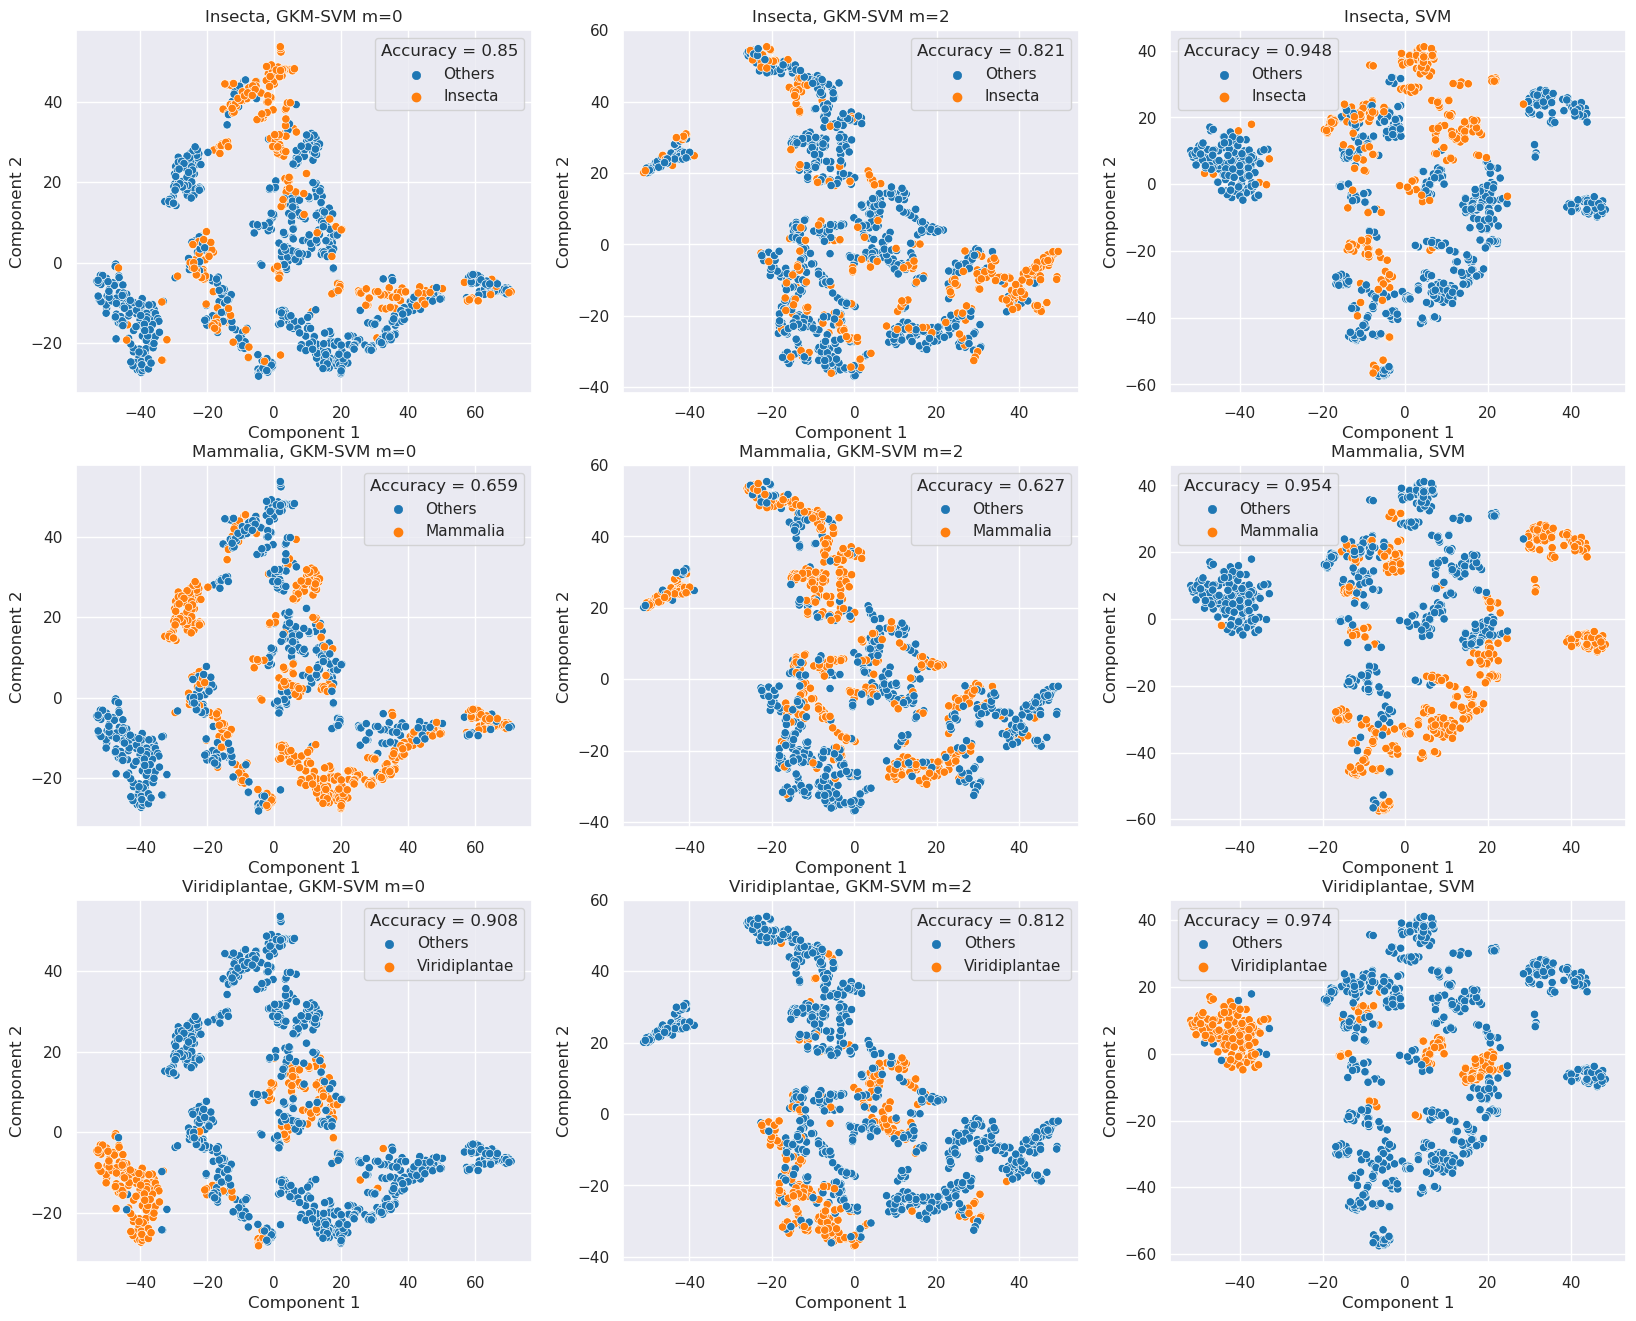

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

In [13]:
custom_palette = sns.color_palette("tab10")
names = ['Insecta', 'Mammalia', 'Viridiplantae']
s = ['i', 'm', 'p']
mismatches = [0, 2]
fig, axis = plt.subplots(3, 3, figsize=(20, 16))
y_ind = -1

for class_k in s:
    x_ind=-1
    y_ind+=1
    
    for m in mismatches:
        x_ind+=1

        
        reader = FastaUtility()
        Xtrain, Ytrain = reader.read_data("/home/parazit/ml_virus_host/v2.0/fastsk/data/crossing/it0/full_crossing_train_"+class_k+"_it0.fasta")
        Xtest, Ytest = reader.read_data("/home/parazit/ml_virus_host/v2.0/fastsk/data/crossing/it0/full_crossing_test_"+class_k+"_it0.fasta")
        Ytest = np.array(Ytest).reshape(-1, 1)

        fastsk = FastSK(g=3, m=m, t=8, approx=True)
        fastsk.compute_kernel(Xtrain, Xtest)

        Xtrain = fastsk.get_train_kernel()
        Xtest = fastsk.get_test_kernel()

        reader = FastaUtility()
        Xseq, Ytrain = reader.read_data("/home/parazit/ml_virus_host/v2.0/fastsk/data/crossing/it0/full_crossing_train_"+class_k+"_it0.fasta")
        svm = SVC(gamma='auto',probability=True, C=1) 
        clf = CalibratedClassifierCV(svm, cv=5).fit(Xtrain, Ytrain)

        acc = clf.score(Xtest, Ytest)
        probs = clf.predict_proba(Xtest)[:,1]
        auc = roc_auc_score(Ytest, probs)
        y_pred = clf.predict(Xtest)
        clfs = classification_report(Ytest, y_pred, target_names=['Others', names[s.index(class_k)]])
        print(clfs)
        print("Gaussian RBF SVM:\n\tAcc = {}, AUC = {}".format(acc, auc))

        plt.figure(figsize=(8, 8))
        tsne = TSNE(n_components=2, random_state=42, perplexity=25)
        X_tsne = tsne.fit_transform(Xtrain)
        
        df_tsne = pd.DataFrame({"Component 1": X_tsne[:,0],
                               "Component 2": X_tsne[:,1],
                                "Host": Ytrain})
                               #"Host": np.concatenate(Ytrain, axis=0)})
        axis[y_ind][x_ind].set(title=names[s.index(class_k)]+', GKM-SVM m='+str(m))
        sns.scatterplot(x="Component 1", y="Component 2", hue="Host", data=df_tsne, alpha=1, ax = axis[y_ind][x_ind], palette='tab10')
        #axis[y_ind][x_ind].plot([], [], 'w-', label="Accuracy = "+ str(round(acc, 3)))
        
        #axis[y_ind][x_ind].legend(labels = ['Others', names[s.index(class_k)], "Accuracy = "+ str(round(acc, 3))]) 
        axis[y_ind][x_ind].legend(title="Accuracy = "+ str(round(acc, 3)), labels = ['Others', names[s.index(class_k)]])
        
        leg = axis[y_ind][x_ind].get_legend()
        leg.legendHandles[0].set_color(custom_palette[0])
        leg.legendHandles[1].set_color(custom_palette[1])
        

i=-1
for y_class, class_name in tqdm(zip(list_y, classes)):
    i+=1
    y_train = y_class[indices_train]
    y_test = y_class[indices_test]
    
    clf = make_pipeline(StandardScaler(), SVC(gamma='auto',probability=True))
    clf = clf.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=25)
    X_tsne = tsne.fit_transform(X_train)
    


    df_tsne = pd.DataFrame({"Component 1": X_tsne[:,0],
                           "Component 2": X_tsne[:,1],
                            "Host": y_train})
                           #"Host": np.concatenate(Ytrain, axis=0)})
    axis[i][2].set(title=names[i]+', SVM')
    sns.scatterplot(x="Component 1", y="Component 2", hue="Host", data=df_tsne, alpha=1, ax=axis[i][2], palette='tab10')

    axis[i][2].legend(title="Accuracy = "+ str(round(acc, 3)), labels = ['Others', names[i]])

    leg = axis[i][2].get_legend()
    leg.legendHandles[0].set_color(custom_palette[0])
    leg.legendHandles[1].set_color(custom_palette[1]) 
    
    
plt.tight_layout()
plt.show()

In [7]:
def draw_svms_classes(SVM_C):
    custom_palette = sns.color_palette("tab10")
    names = ['Insecta', 'Mammalia', 'Viridiplantae']
    s = ['i', 'm', 'p']
    mismatches = [0, 2]
    fig, axis = plt.subplots(3, 3, figsize=(20, 16))
    y_ind = -1

    #SVM_C = 10**-2


    for class_k in s:
        x_ind=-1
        y_ind+=1

        for m in mismatches:
            x_ind+=1


            reader = FastaUtility()
            Xtrain, Ytrain = reader.read_data("/home/parazit/ml_virus_host/v2.0/fastsk/data/crossing/it0/full_crossing_train_"+class_k+"_it0.fasta")
            Xtest, Ytest = reader.read_data("/home/parazit/ml_virus_host/v2.0/fastsk/data/crossing/it0/full_crossing_test_"+class_k+"_it0.fasta")
            Ytest = np.array(Ytest).reshape(-1, 1)

            fastsk = FastSK(g=3, m=m, t=8, approx=True)
            fastsk.compute_kernel(Xtrain, Xtest)

            Xtrain = fastsk.get_train_kernel()
            Xtest = fastsk.get_test_kernel()

            reader = FastaUtility()
            Xseq, Ytrain = reader.read_data("/home/parazit/ml_virus_host/v2.0/fastsk/data/crossing/it0/full_crossing_train_"+class_k+"_it0.fasta")
            '''
            svm = SVC(gamma='auto',probability=True, C=1) 
            clf = CalibratedClassifierCV(svm, cv=5).fit(Xtrain, Ytrain)
            '''
            clf = make_pipeline(StandardScaler(), SVC(gamma='auto',probability=True, C=SVM_C)).fit(Xtrain, Ytrain)

            acc = clf.score(Xtest, Ytest)
            
            probs = clf.predict_proba(Xtest)[:,1]
            auc = roc_auc_score(Ytest, probs)
            y_pred = clf.predict(Xtest)
            f1 = f1_score(Ytest, y_pred)
            
            clfs = classification_report(Ytest, y_pred, target_names=['Others', names[s.index(class_k)]])
            print(clfs)
            print("Gaussian RBF SVM:\n\tAcc = {}, AUC = {}".format(acc, auc))

            plt.figure(figsize=(8, 8))
            tsne = TSNE(n_components=2, random_state=42, perplexity=25)
            X_tsne = tsne.fit_transform(Xtrain)

            df_tsne = pd.DataFrame({"Component 1": X_tsne[:,0],
                                   "Component 2": X_tsne[:,1],
                                    "Host": Ytrain})
                                   #"Host": np.concatenate(Ytrain, axis=0)})
            axis[y_ind][x_ind].set(title=names[s.index(class_k)]+', GKM-SVM m='+str(m)+', C='+str(SVM_C))
            sns.scatterplot(x="Component 1", y="Component 2", hue="Host", data=df_tsne, alpha=1, ax = axis[y_ind][x_ind], palette='tab10')
            #axis[y_ind][x_ind].plot([], [], 'w-', label="Accuracy = "+ str(round(acc, 3)))

            #axis[y_ind][x_ind].legend(labels = ['Others', names[s.index(class_k)], "Accuracy = "+ str(round(acc, 3))]) 
            axis[y_ind][x_ind].legend(title="Accuracy = "+ str(round(acc, 3))+'\nf1-score = '+str(round(f1, 3)), labels = ['Others', names[s.index(class_k)]])

            leg = axis[y_ind][x_ind].get_legend()
            leg.legendHandles[0].set_color(custom_palette[0])
            leg.legendHandles[1].set_color(custom_palette[1])


    i=-1
    for y_class, class_name in tqdm(zip(list_y, classes)):
        i+=1
        y_train = y_class[indices_train]
        y_test = y_class[indices_test]

        clf = make_pipeline(StandardScaler(), SVC(gamma='auto',probability=True, C=SVM_C)).fit(X_train, y_train)

        #svm = SVC(gamma='auto',probability=True, C=1) 
        #clf = CalibratedClassifierCV(svm, cv=5).fit(X_train, y_train)

        acc = clf.score(X_test, y_test)
        probs = clf.predict_proba(X_test)[:,1]
        y_pred = clf.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        
        tsne = TSNE(n_components=2, random_state=42, perplexity=25)
        X_tsne = tsne.fit_transform(X_train)
    


        df_tsne = pd.DataFrame({"Component 1": X_tsne[:,0],
                               "Component 2": X_tsne[:,1],
                                "Host": y_train})
                               #"Host": np.concatenate(Ytrain, axis=0)})
        axis[i][2].set(title=names[i]+', SVM'+', C='+str(SVM_C))
        sns.scatterplot(x="Component 1", y="Component 2", hue="Host", data=df_tsne, alpha=1, ax=axis[i][2], palette='tab10')

        axis[i][2].legend(title="Accuracy = "+ str(round(acc, 3))+'\nf1-score = '+str(round(f1, 3)), labels = ['Others', names[i]])

        leg = axis[i][2].get_legend()
        leg.legendHandles[0].set_color(custom_palette[0])
        leg.legendHandles[1].set_color(custom_palette[1]) 


    plt.tight_layout()
    plt.show()
    return

In [ ]:
for i in [10**-2, 10**-1, 10**-0, 10**1, 10**2]:
    print(i)
    draw_svms_classes(i)

0.01
Length of shortest train sequence: 2066
Length of shortest test sequence: 4139
Dictionary size = 16 (+1 for unknown char).
g = 3, k = 3, 14985273 features
Initializing kernel function


/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/parazit/anaconda3/lib/

              precision    recall  f1-score   support

      Others       0.77      1.00      0.87       265
     Insecta       0.00      0.00      0.00        81

    accuracy                           0.77       346
   macro avg       0.38      0.50      0.43       346
weighted avg       0.59      0.77      0.66       346

Gaussian RBF SVM:
	Acc = 0.7658959537572254, AUC = 0.8697880270207313
Computing approximate kernel...
Computing 1 mismatch profiles using 1 threads...
Thread 0 finished in 1 iterations...
Length of shortest train sequence: 2066
Length of shortest test sequence: 4139
Dictionary size = 16 (+1 for unknown char).
g = 3, k = 1, 14985273 features
Initializing kernel function


/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/parazit/anaconda3/lib/

              precision    recall  f1-score   support

      Others       0.77      1.00      0.87       265
     Insecta       0.00      0.00      0.00        81

    accuracy                           0.77       346
   macro avg       0.38      0.50      0.43       346
weighted avg       0.59      0.77      0.66       346

Gaussian RBF SVM:
	Acc = 0.7658959537572254, AUC = 0.7689261588632659
Computing approximate kernel...
Computing 3 mismatch profiles using 3 threads...
Thread 2 finished in 1 iterations...
Thread 0 finished in 1 iterations...
Thread 1 finished in 1 iterations...
Length of shortest train sequence: 2066
Length of shortest test sequence: 4139
Dictionary size = 16 (+1 for unknown char).
g = 3, k = 3, 14985273 features
Initializing kernel function
              precision    recall  f1-score   support

      Others       0.56      1.00      0.72       171
    Mammalia       1.00      0.25      0.39       175

    accuracy                           0.62       346
   macro 

/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Computing approximate kernel...
Computing 1 mismatch profiles using 1 threads...
Thread 0 finished in 1 iterations...
Length of shortest train sequence: 2066
Length of shortest test sequence: 4139
Dictionary size = 16 (+1 for unknown char).
g = 3, k = 1, 14985273 features
Initializing kernel function


/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/parazit/anaconda3/lib/

              precision    recall  f1-score   support

      Others       0.49      1.00      0.66       171
    Mammalia       0.00      0.00      0.00       175

    accuracy                           0.49       346
   macro avg       0.25      0.50      0.33       346
weighted avg       0.24      0.49      0.33       346

Gaussian RBF SVM:
	Acc = 0.49421965317919075, AUC = 0.709908103592314


In [7]:
def draw_svms_full(SVM_C):
    custom_palette = sns.color_palette("tab10")
    names = ['Insecta', 'Mammalia', 'Viridiplantae']
    s = ['i', 'm', 'p']
    mismatches = [0, 2]
    #fig, axis = plt.subplots(3, 3, figsize=(20, 16))
    y_ind = -1

    y_proba = np.zeros(shape=indices_test.shape)
    for m in mismatches:
        
        y_proba = np.zeros(shape=indices_test.shape)
        for class_k in s:
    

            reader = FastaUtility()
            Xtrain, Ytrain = reader.read_data("/home/parazit/ml_virus_host/v2.0/fastsk/data/crossing/it0/full_crossing_train_"+class_k+"_it0.fasta")
            Xtest, Ytest = reader.read_data("/home/parazit/ml_virus_host/v2.0/fastsk/data/crossing/it0/full_crossing_test_"+class_k+"_it0.fasta")
            Ytest = np.array(Ytest).reshape(-1, 1)

            fastsk = FastSK(g=3, m=m, t=8, approx=True)
            fastsk.compute_kernel(Xtrain, Xtest)

            Xtrain = fastsk.get_train_kernel()
            Xtest = fastsk.get_test_kernel()

            reader = FastaUtility()
            Xseq, Ytrain = reader.read_data("/home/parazit/ml_virus_host/v2.0/fastsk/data/crossing/it0/full_crossing_train_"+class_k+"_it0.fasta")
             
            clf = make_pipeline(StandardScaler(), SVC(gamma='auto',probability=True, C=SVM_C)).fit(Xtrain, Ytrain)
            y_proba = np.vstack((y_proba, clf.predict_proba(Xtest)[:,1]))
        
                    
        y_proba = y_proba[1:]
        y_proba = (y_proba/y_proba.sum(axis=0))
        y_pred_all = np.argmax(y_proba, axis=0)
        print('F1-score (weighted):', round(f1_score(y_int[test_indices_crossing['i']], y_pred_all, average='weighted'), 2))
        print('F1-score (macro):', round(f1_score(y_int[indices_test], y_pred_all, average='macro'), 2))   
        '''
        plt.figure(figsize=(8, 8))
        tsne = TSNE(n_components=2, random_state=42, perplexity=25)
        X_tsne = tsne.fit_transform(Xtrain)

        df_tsne = pd.DataFrame({"Component 1": X_tsne[:,0],
                               "Component 2": X_tsne[:,1],
                                "Host": Ytrain})
                               #"Host": np.concatenate(Ytrain, axis=0)})
        axis[y_ind][x_ind].set(title=names[s.index(class_k)]+', GKM-SVM m='+str(m)+', C='+str(SVM_C))
        sns.scatterplot(x="Component 1", y="Component 2", hue="Host", data=df_tsne, alpha=1, ax = axis[y_ind][x_ind], palette='tab10')
        #axis[y_ind][x_ind].plot([], [], 'w-', label="Accuracy = "+ str(round(acc, 3)))

        #axis[y_ind][x_ind].legend(labels = ['Others', names[s.index(class_k)], "Accuracy = "+ str(round(acc, 3))]) 
        axis[y_ind][x_ind].legend(title="Accuracy = "+ str(round(acc, 3))+'\nf1-score = '+str(round(f1, 3)), labels = ['Others', names[s.index(class_k)]])

        leg = axis[y_ind][x_ind].get_legend()
        leg.legendHandles[0].set_color(custom_palette[0])
        leg.legendHandles[1].set_color(custom_palette[1])


    i=-1
    for y_class, class_name in tqdm(zip(list_y, classes)):
        i+=1
        y_train = y_class[indices_train]
        y_test = y_class[indices_test]

        clf = make_pipeline(StandardScaler(), SVC(gamma='auto',probability=True, C=SVM_C)).fit(X_train, y_train)

        #svm = SVC(gamma='auto',probability=True, C=1) 
        #clf = CalibratedClassifierCV(svm, cv=5).fit(X_train, y_train)

        acc = clf.score(X_test, y_test)
        probs = clf.predict_proba(X_test)[:,1]
        y_pred = clf.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        
        tsne = TSNE(n_components=2, random_state=42, perplexity=25)
        X_tsne = tsne.fit_transform(X_train)
    


        df_tsne = pd.DataFrame({"Component 1": X_tsne[:,0],
                               "Component 2": X_tsne[:,1],
                                "Host": y_train})
                               #"Host": np.concatenate(Ytrain, axis=0)})
        axis[i][2].set(title=names[i]+', SVM'+', C='+str(SVM_C))
        sns.scatterplot(x="Component 1", y="Component 2", hue="Host", data=df_tsne, alpha=1, ax=axis[i][2], palette='tab10')

        axis[i][2].legend(title="Accuracy = "+ str(round(acc, 3))+'\nf1-score = '+str(round(f1, 3)), labels = ['Others', names[i]])

        leg = axis[i][2].get_legend()
        leg.legendHandles[0].set_color(custom_palette[0])
        leg.legendHandles[1].set_color(custom_palette[1]) 


    plt.tight_layout()
    plt.show()
    '''
    return

In [8]:
meta_df=pd.read_csv(PATH_FASTSK_DATA+'data_table.tsv', sep='\t', index_col='refseq id')
meta_df['indices'] = list(range(len(meta_df)))

test_ids, train_ids, test_indices_crossing, train_indices_crossing = [], [], {}, {}
for class_k in ['i', 'm', 'p']:
    test_index = []
    train_index = []
    seq_id_test = []
    with open(PATH_FASTSK_DATA+'crossing/it0/full_crossing_test_'+ class_k +'_it0.fasta', 'r') as test_f, \
    open(PATH_FASTSK_DATA+'crossing/it0/full_crossing_train_'+ class_k +'_it0.fasta', 'r') as train_f:
        i = -1
        for seq in SeqIO.parse(PATH_DATA+'data.fasta', 'fasta'):
            i+=1
            #print(seq.id)
            if not i == meta_df.loc[seq.id]['indices']:
                print('FAIL')
            if seq.id in future_sample_id_crossing:
                seq_id_test.append(seq.id)
                test_index.append(i)
                #seq.description = str(meta_df.loc[seq.id][class_k])
                #seq.id = seq.description
                #SeqIO.write(seq, test_f, 'fasta-2line')
            else:
                train_index.append(i)
                #seq.description = str(meta_df.loc[seq.id][class_k])
                #seq.id = seq.description
                #SeqIO.write(seq, train_f, 'fasta-2line')
                
                  
    test_indices_crossing[class_k] = test_index
    train_indices_crossing[class_k] = train_index

In [ ]:
draw_svms_full(1)

Length of shortest train sequence: 2066
Length of shortest test sequence: 4139
Dictionary size = 16 (+1 for unknown char).
g = 3, k = 3, 14985273 features
Initializing kernel function
Computing approximate kernel...
Computing 1 mismatch profiles using 1 threads...
Thread 0 finished in 1 iterations...
Length of shortest train sequence: 2066
Length of shortest test sequence: 4139
Dictionary size = 16 (+1 for unknown char).
g = 3, k = 3, 14985273 features
Initializing kernel function


In [18]:
test_indices_crossing['i'] == test_indices_crossing['m']

True

In [10]:
for y_class, class_name in tqdm(zip(list_y, classes)):
        y_train = y_class[indices_train]
        y_test = y_class[indices_test]

        clf = make_pipeline(StandardScaler(), SVC(gamma='auto',probability=True, C=1)).fit(X_train, y_train)


3it [00:00, 11.63it/s]


In [62]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto',probability=True, C=1))#.fit(X_train, y_train)

In [63]:
clf[1].support_vectors_

AttributeError: 'SVC' object has no attribute 'support_vectors_'

In [60]:
clf[1].support_vectors_

array([[-0.68550189, -0.05355139,  1.90902328, ..., -0.99518018,
         1.02003014, -0.94297791],
       [-0.72070265,  2.13585333, -0.79207592, ..., -0.44409292,
        -0.14210864, -0.33141373],
       [-0.85776955,  0.83522911, -1.12681783, ...,  0.86310936,
         0.5047671 ,  0.66768121],
       ...,
       [-0.26291955, -0.54652091, -0.02961554, ..., -0.10130198,
        -1.30112491, -1.03150586],
       [ 0.2231723 ,  0.32351845,  1.63794041, ...,  0.18188422,
         0.55499622, -0.3654939 ],
       [-0.38174048,  0.80951139,  0.88641951, ..., -0.46326828,
         0.31156909, -0.71981919]])

In [ ]:
y_train[clf[1].support_]